In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 71.6MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 9.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=d73e10ed0498b221896c96e4c5edb3121e88b810ccc0786dcd8b371ecd7dac41
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-1369szxv
  Running command git 

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 1.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200418-cp36-none-any.whl size=39841 sha256=0d8ebd981ba039dea2197c0e49ae5fc8e81bdc58ebbe4c4b415e7b3bd9b39715
  Stored in directory: /root/.cache/pip/wheels/b1/12/78/80c8ca3ed004727389251ab1b992009519479c706acb70db3c
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
!unzip mini_data.zip

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
categories=[]

def get_lyft_dicts(set): #dir: mini_data, set: train o val 
    dir="mini_data"
    json_file = os.path.join(".",dir,"detections.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)[set]
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns):
        record = {}
        
        filename = os.path.join(".",dir,set,list(v.keys())[0]+".jpg")
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v[list(v.keys())[0]]['detections']
        objs = []
        for anno in annos:
            px = anno["box"][0]
            py = anno["box"][1]
            if anno["name"] not in categories:
                categories.append(anno["name"])
            cat = categories.index(anno["name"])
            obj = {
                "bbox": [px[0], py[0], px[1], py[1]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": cat,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts
get_lyft_dicts("train")
print(categories)

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("lyft_" + d, lambda d=d: get_lyft_dicts(d))
    MetadataCatalog.get("lyft_" + d).set(thing_classes=categories)
lyft_metadata = MetadataCatalog.get("lyft_train")

['car', 'bicycle', 'pedestrian', 'truck', 'bus', 'other_vehicle', 'animal', 'emergency_vehicle', 'motorcycle']


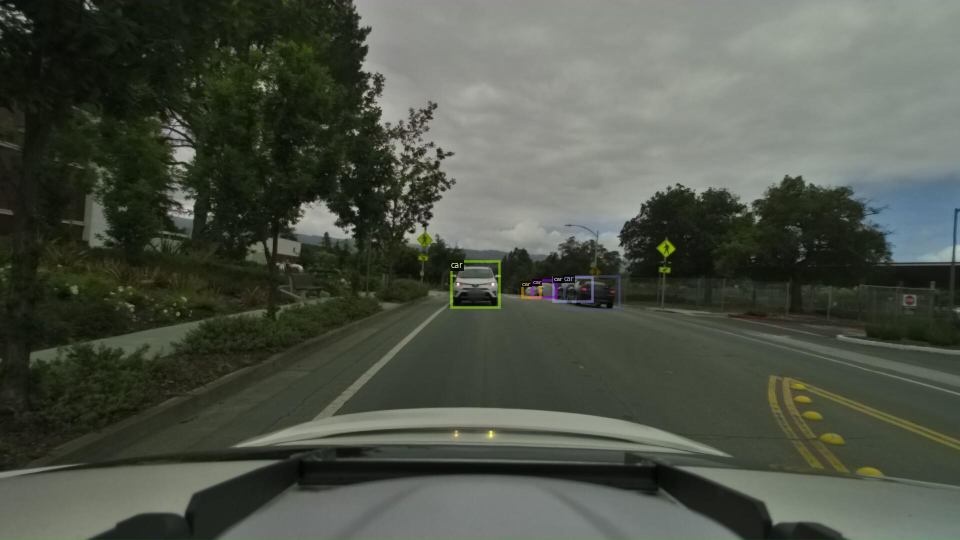

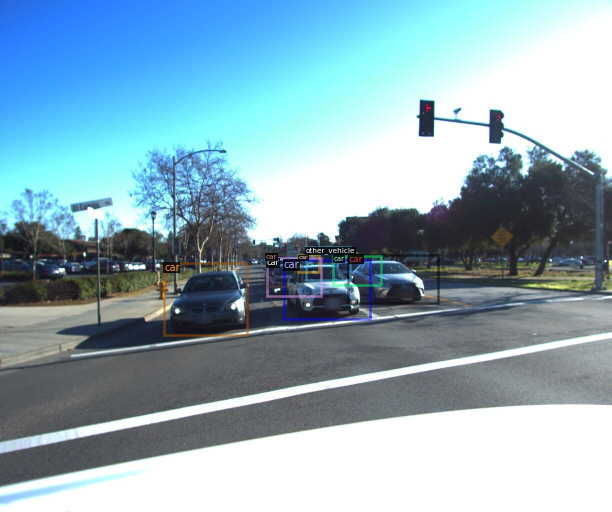

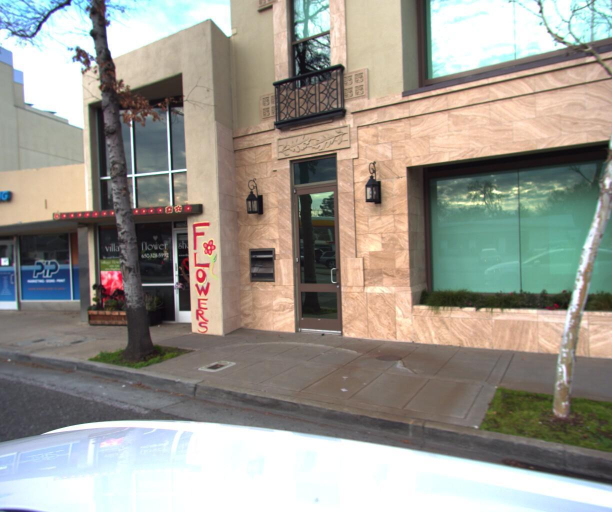

500

In [16]:
dataset_dicts = get_lyft_dicts("train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=lyft_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

len(dataset_dicts)

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("lyft_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/19 22:15:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:15, 10.5MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (10, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (10,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (36, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (36,) in the model! Skipped.


[04/19 22:15:29 d2.engine.train_loop]: Starting training from iteration 0
[04/19 22:15:34 d2.utils.events]:  eta: 0:01:15  iter: 19  total_loss: 3.401  loss_cls: 2.358  loss_box_reg: 0.756  loss_rpn_cls: 0.080  loss_rpn_loc: 0.081  time: 0.2721  data_time: 0.0177  lr: 0.000005  max_mem: 2644M
[04/19 22:15:39 d2.utils.events]:  eta: 0:01:09  iter: 39  total_loss: 3.328  loss_cls: 2.265  loss_box_reg: 0.817  loss_rpn_cls: 0.107  loss_rpn_loc: 0.073  time: 0.2642  data_time: 0.0047  lr: 0.000010  max_mem: 2644M
[04/19 22:15:45 d2.utils.events]:  eta: 0:01:03  iter: 59  total_loss: 2.919  loss_cls: 2.045  loss_box_reg: 0.704  loss_rpn_cls: 0.107  loss_rpn_loc: 0.076  time: 0.2635  data_time: 0.0047  lr: 0.000015  max_mem: 2729M
[04/19 22:15:50 d2.utils.events]:  eta: 0:00:58  iter: 79  total_loss: 2.753  loss_cls: 1.742  loss_box_reg: 0.771  loss_rpn_cls: 0.071  loss_rpn_loc: 0.057  time: 0.2633  data_time: 0.0057  lr: 0.000020  max_mem: 2729M
[04/19 22:15:55 d2.utils.events]:  eta: 0:00:5

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
cfg.DATASETS.TEST = ("lyft_val", )
predictor = DefaultPredictor(cfg)

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_lyft_dicts("val")
prediction_box=[]
prediction_class=[]

for d in dataset_dicts:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=lyft_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    prediction_box.append(outputs["instances"].pred_boxes)
    prediction_class.append(outputs["instances"].pred_classes)
    print(outputs["instances"].pred_classes)
    print(outputs["instances"].pred_boxes)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[ 847.5663,  505.5796, 1001.5474,  583.9777],
        [ 581.6097,  479.0482,  674.2373,  587.8334],
        [ 536.3913,  488.8228,  717.4069,  587.2125],
        [ 716.9359,  503.2214,  767.5545,  540.7765],
        [ 433.5404,  518.5074,  523.2047,  588.0072],
        [ 814.4741,  497.8091,  979.6232,  614.0135],
        [ 471.7427,  511.9680,  539.8076,  580.0739],
        [ 456.7542,  467.8038,  581.7582,  578.7863],
        [ 700.9772,  500.8858,  790.9480,  544.5372],
        [ 563.3526,  496.1846,  672.8922,  556.1373],
        [ 458.0673,  503.6620,  506.3093,  595.2499],
        [1061.5497,  513.1266, 1156.4076,  550.3397],
        [ 820.4343,  517.9084,  948.5156,  584.7144]], device='cuda:0'))
tensor([0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[ 625.5999,  521.0670,  692.8610,  574.3274],
        [ 716.8975,  532.0138,  839.6346,  577.0552],
        [   0.0000,  510.5484,  281.6659,  788.2625],

In [14]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_lyft_dicts("val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=lyft_metadata, 
                   scale=0.8, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("lyft_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "lyft_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [04/19 22:22:34 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'lyft_val'. Trying to convert it to COCO format ...
[04/19 22:22:34 d2.data.datasets.coco]: Converting dataset annotations in 'lyft_val' to COCO format ...)
[04/19 22:22:36 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/19 22:22:36 d2.data.datasets.coco]: Conversion finished, num images: 150, num annotations: 901
[04/19 22:22:36 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/lyft_val_coco_format.json
[04/19 22:22:39 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |   category    | #instances   |   category    | #instances   |
|:----------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    car     | 773          |    bicycle    | 21           |  pedestrian   | 27           |
|   truck    | 13           |      bus      | 11           | other_vehicle | 55           

OrderedDict([('bbox',
              {'AP': 2.474495661197622,
               'AP-animal': nan,
               'AP-bicycle': 0.0,
               'AP-bus': 0.0,
               'AP-car': 17.321469628383355,
               'AP-emergency_vehicle': 0.0,
               'AP-motorcycle': nan,
               'AP-other_vehicle': 0.0,
               'AP-pedestrian': 0.0,
               'AP-truck': 0.0,
               'AP50': 6.307873837986739,
               'AP75': 1.025842493619992,
               'APl': 4.742697783043684,
               'APm': 2.0366584387633093,
               'APs': 0.621703874403773})])

In [0]:
from sklearn.metrics import f1_score
box_val=[]
class_val=[]
for i in range(len(dataset_dicts)):
  for j in range(len(dataset_dicts[i]["annotations"])):
      box_val.append(dataset_dicts[i]["annotations"][j]['bbox'])
      class_val.append(dataset_dicts[i]["annotations"][j]['category_id'])

In [0]:
predicciones_box=[]
predicciones_classes=[]

sume=0
for i in range(len(prediction_box)):
  for j in range(len(prediction_box[i])):
    previo=prediction_box[i][j].to('cpu')
    anno=previo.tensor.numpy()
    anno=anno.reshape((len(box_val[0])))
    predicciones_box.append(anno)
    previo2=prediction_class[i][j].to('cpu')
    anno2=previo2.numpy()
    predicciones_classes.append(anno2)


In [0]:
from sklearn.metrics import confusion_matrix
M=confusion_matrix(class_val,predicciones_classes[:901])
plot_confusion_matrix(M,['car', 'bicycle', 'pedestrian', 'truck', 'bus', 'other_vehicle', 'animal', 'emergency_vehicle', 'motorcycle'])

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')